In [59]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

load data

In [60]:
items=pd.read_csv("./kaggle/items.csv")
shops=pd.read_csv("./kaggle/shops.csv")
cats=pd.read_csv("./kaggle/item_categories.csv")
train=pd.read_csv("./kaggle/sales_train.csv")
test=pd.read_csv("./kaggle/test.csv")

Data Cleaning

<AxesSubplot: xlabel='item_cnt_day'>

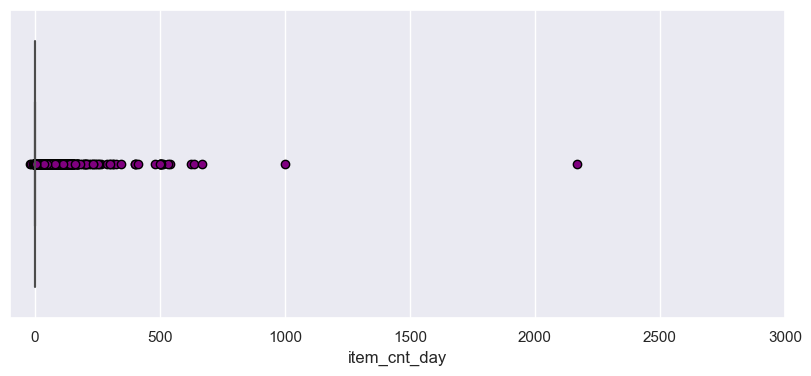

In [61]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train.item_cnt_day, flierprops=flierprops)

<AxesSubplot: xlabel='item_price'>

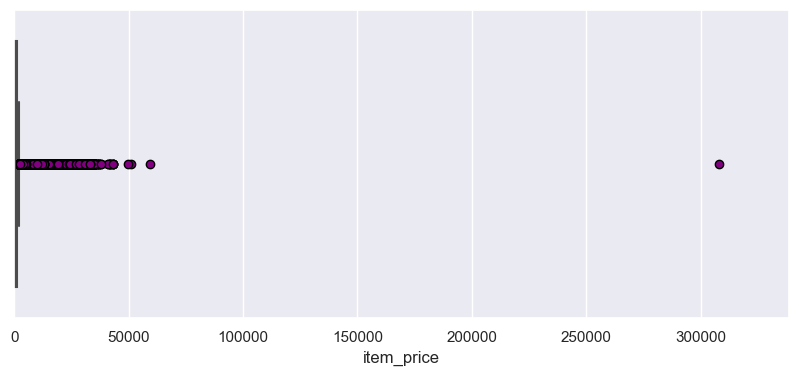

In [62]:
plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price, flierprops=flierprops)

Remove outlier

In [63]:
train = train[(train.item_price < 300000 )& (train.item_cnt_day < 1000)]
# remove negative item price
train = train[train.item_price > 0].reset_index(drop = True)

Cleaning shops data<br>
Якутск Орджоникидзе, 56

In [64]:
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

Clean up some shop names and add 'city' and 'category' to shops df.

In [65]:
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"

Only keep shop category if there are 5 or more shops of that category, the rest are grouped as "other".

In [66]:
category = []
for cat in shops.category.unique():
    if len(shops[shops.category == cat]) >= 5:
        category.append(cat)    
shops.category = shops.category.apply( lambda x: x if (x in category) else "other" )

label encoding

In [67]:
from sklearn.preprocessing import LabelEncoder
shops["shop_category"] = LabelEncoder().fit_transform( shops.category )
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )
shops = shops[["shop_id", "shop_category", "shop_city"]]

Cleaning Item Category Data

In [68]:
cats["type_code"] = cats.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)
cats.loc[ (cats.type_code == "Игровые")| (cats.type_code == "Аксессуары"), "category" ] = "Игры"
category = []
for cat in cats.type_code.unique():
    if len(cats[cats.type_code == cat]) >= 5: 
        category.append( cat )
cats.type_code = cats.type_code.apply(lambda x: x if (x in category) else "etc")
# Label Encoding
cats.type_code = LabelEncoder().fit_transform(cats.type_code)
cats["split"] = cats.item_category_name.apply(lambda x: x.split("-"))
cats["subtype"] = cats.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats["subtype_code"] = LabelEncoder().fit_transform( cats["subtype"] )
cats = cats[["item_category_id", "subtype_code", "type_code"]]

Cleaning Item Data

In [69]:
import re
def name_correction(x):
    x = x.lower() # all letters lower case
    x = x.partition('[')[0] # partition by square brackets
    x = x.partition('(')[0] # partition by curly brackets
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x
  
 # Cleaning Item name
# split item names by first bracket
items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

/var/folders/gx/mwghkzgj4mx14pnn9jrnjqym0000gn/T/ipykernel_37887/1913025211.py:13: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
/var/folders/gx/mwghkzgj4mx14pnn9jrnjqym0000gn/T/ipykernel_37887/1913025211.py:13: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
/var/folders/gx/mwghkzgj4mx14pnn9jrnjqym0000gn/T/ipykernel_37887/1913025211.py:14: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  items["name1"], items["name3"] = items.item_name.str.split("(", 1).str
/var/folders/gx/mwghkzgj4mx14pnn9jrnjqym0000gn/T/ipykernel_37887/1913025211.py:14: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  i

replace special characters and turn to lower case

In [70]:
items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

/var/folders/gx/mwghkzgj4mx14pnn9jrnjqym0000gn/T/ipykernel_37887/3102718423.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
/var/folders/gx/mwghkzgj4mx14pnn9jrnjqym0000gn/T/ipykernel_37887/3102718423.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()


fill nulls with '0'

In [71]:
items = items.fillna('0')

In [72]:
items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))

return all characters except the last if name 2 is not "0" - the closing bracket

In [73]:
items.name2 = items.name2.apply( lambda x: x[:-1] if x !="0" else "0")

clean item type

In [74]:
items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

In [75]:
group_sum = items.groupby(["type"]).agg({"item_id": "count"})
group_sum = group_sum.reset_index()
drop_cols = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_cols.append(cat)
items.name2 = items.name2.apply( lambda x: "other" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)

In [76]:
items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)

In [77]:
items.drop(["item_name", "name1"],axis = 1, inplace= True)
items.head()

,item_id,item_category_id,name2,name3
0,0,40,4,1331
1,1,76,64,42
2,2,40,4,1011
3,3,40,4,1010
4,4,40,4,1572


Preprocessing create a matrix df with every combination of month, shop and item in order of increasing month. Item_cnt_day is summed into an item_cnt_month.

In [78]:
from itertools import product
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )

In [79]:
matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )

add revenue to train df

In [80]:
train["revenue"] = train["item_cnt_day"] * train["item_price"]
group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16)

Create a test set for month 34.

In [81]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)

Concatenate train and test sets.

In [82]:
matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna( 0, inplace = True )

Add shop, items and categories data onto matrix df.

In [83]:
matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, cats, on = ["item_category_id"], how = "left" )
matrix["shop_city"] = matrix["shop_city"].astype(np.int8)
matrix["shop_category"] = matrix["shop_category"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["subtype_code"] = matrix["subtype_code"].astype(np.int8)
matrix["name2"] = matrix["name2"].astype(np.int8)
matrix["name3"] = matrix["name3"].astype(np.int16)
matrix["type_code"] = matrix["type_code"].astype(np.int8)

Feature Engineering, add lag features to matrix df.<br>
Define a lag feature function

In [84]:
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df
  
# Add item_cnt_month lag features. 
matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] )

item_cnt_month


Add the previous month's average item_cnt.

In [85]:
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)
matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1], ["date_avg_item_cnt"] )
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )

date_avg_item_cnt


Add lag values of item_cnt_month for month / item_id.

In [86]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

In [87]:
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix.date_item_avg_item_cnt = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], ['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

date_item_avg_item_cnt


Add lag values for item_cnt_month for every month / shop combination.

In [88]:
group = matrix.groupby( ["date_block_num","shop_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_avg_item_cnt"]
group.reset_index(inplace = True)
matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_avg_item_cnt"] )
matrix.drop( ["date_shop_avg_item_cnt"], axis = 1, inplace = True )

/var/folders/gx/mwghkzgj4mx14pnn9jrnjqym0000gn/T/ipykernel_37887/2858148095.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  matrix.date_avg_item_cnt = matrix["date_shop_avg_item_cnt"].astype(np.float16)


date_shop_avg_item_cnt


Add lag values for item_cnt_month for month/shop/item.

In [89]:
group = matrix.groupby( ["date_block_num","shop_id","item_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_item_avg_item_cnt"]
group.reset_index(inplace = True)
matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id","item_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_item_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_item_avg_item_cnt"] )
matrix.drop( ["date_shop_item_avg_item_cnt"], axis = 1, inplace = True )

/var/folders/gx/mwghkzgj4mx14pnn9jrnjqym0000gn/T/ipykernel_37887/3373283866.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  matrix.date_avg_item_cnt = matrix["date_shop_item_avg_item_cnt"].astype(np.float16)


date_shop_item_avg_item_cnt


Add lag values for item_cnt_month for month/shop/item subtype.

In [90]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

In [91]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix.date_shop_subtype_avg_item_cnt = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_shop_subtype_avg_item_cnt'])
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

date_shop_subtype_avg_item_cnt


Add lag values for item_cnt_month for month/city.

In [92]:
group = matrix.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', "shop_city"], how='left')
matrix.date_city_avg_item_cnt = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_city_avg_item_cnt'])
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

date_city_avg_item_cnt


Add lag values for item_cnt_month for month/city/item.

In [93]:
group = matrix.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_city'], how='left')
matrix.date_item_city_avg_item_cnt = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_item_city_avg_item_cnt'])
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

date_item_city_avg_item_cnt


Add average item price on to matix df., add lag values of item price per month<br>
Add delta price values - how current month average pirce relates to global average.

In [94]:
group = train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)
matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)
group = train.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)
matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_price"] )
for i in lags:
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]

date_item_avg_item_price


In [95]:
def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

In [96]:
matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

In [97]:
features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)

Add total shop revenue per month to matix df. Add lag values of revenue per month.<br>
Add delta revenue values - how current month revenue relates to global average.

In [98]:
group = train.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
group.columns = ["date_shop_revenue"]
group.reset_index(inplace = True)

In [99]:
matrix = matrix.merge( group , on = ["date_block_num", "shop_id"], how = "left" )
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

In [100]:
group = group.groupby(["shop_id"]).agg({ "date_block_num":["mean"] })
group.columns = ["shop_avg_revenue"]
group.reset_index(inplace = True )

In [101]:
matrix = matrix.merge( group, on = ["shop_id"], how = "left" )
matrix["shop_avg_revenue"] = matrix.shop_avg_revenue.astype(np.float32)
matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

In [102]:
matrix = lag_feature(matrix, [1], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
matrix.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)

delta_revenue


Add month and number of days in each month to matrix df.

In [103]:
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

Add the month of each shop and item first sale.

In [104]:
matrix["item_shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id"])["date_block_num"].transform('min')

Delete first three months from matrix. They don't have lag values.

In [105]:
matrix = matrix[matrix["date_block_num"] > 3]

Model

In [106]:
import gc
import pickle
from xgboost import XGBRegressor
from matplotlib.pylab import rcParams

In [107]:
data = matrix.copy()
del matrix
gc.collect()
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)
del data
gc.collect();

Training

In [108]:
model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    seed=42)

In [109]:
model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

/usr/local/lib/python3.10/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.17485	validation_1-rmse:1.11651
[1]	validation_0-rmse:1.12457	validation_1-rmse:1.07832
[2]	validation_0-rmse:1.08155	validation_1-rmse:1.04698
[3]	validation_0-rmse:1.04464	validation_1-rmse:1.02135
[4]	validation_0-rmse:1.01425	validation_1-rmse:1.00228
[5]	validation_0-rmse:0.98733	validation_1-rmse:0.98523
[6]	validation_0-rmse:0.96479	validation_1-rmse:0.97298
[7]	validation_0-rmse:0.94610	validation_1-rmse:0.96155
[8]	validation_0-rmse:0.92850	validation_1-rmse:0.95049
[9]	validation_0-rmse:0.91328	validation_1-rmse:0.94173
[10]	validation_0-rmse:0.90001	validation_1-rmse:0.93456
[11]	validation_0-rmse:0.88852	validation_1-rmse:0.92927
[12]	validation_0-rmse:0.87889	validation_1-rmse:0.92367
[13]	validation_0-rmse:0.87016	validation_1-rmse:0.91852
[14]	validation_0-rmse:0.86108	validation_1-rmse:0.91794
[15]	validation_0-rmse:0.85427	validation_1-rmse:0.91494
[16]	validation_0-rmse:0.84827	validation_1-rmse:0.91244
[17]	validation_0-rmse:0.84256	validation

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.100000001, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=10, max_leaves=0, min_child_weight=0.5, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [110]:
rcParams['figure.figsize'] = 12, 4

Testing

In [116]:
X_test.head(10)

,date_block_num,shop_id,item_id,shop_category,shop_city,item_category_id,name2,name3,subtype_code,type_code,...,date_shop_item_avg_item_cnt_lag_3,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_first_sale,item_first_sale
10913804,34,5,5037,3,3,19,89,42,10,3,...,3.0,0.447021,0.194336,0.0,-0.222046,64717.824219,10,30,14,14
10913805,34,5,5320,3,3,55,4,42,2,7,...,NaN,NaN,NaN,NaN,0.000000,NaN,10,30,0,0
10913806,34,5,5233,3,3,19,76,701,10,3,...,1.0,0.447021,0.194336,1.0,0.496826,64717.824219,10,30,7,7
10913807,34,5,5232,3,3,23,123,617,16,3,...,1.0,0.349121,0.194336,0.0,0.505371,64717.824219,10,30,3,3
10913808,34,5,5268,3,3,20,94,42,11,3,...,NaN,NaN,NaN,NaN,0.000000,NaN,10,30,0,0
10913809,34,5,5039,3,3,23,-127,42,16,3,...,0.0,0.349121,0.194336,1.0,-0.210693,64717.824219,10,30,14,14
10913810,34,5,5041,3,3,20,96,42,11,3,...,NaN,0.684082,0.194336,2.0,0.031342,64717.824219,10,30,2,2
10913811,34,5,5046,3,3,55,4,42,2,7,...,0.0,0.158203,0.194336,0.0,0.080505,64717.824219,10,30,12,12
10913812,34,5,5319,3,3,55,4,42,2,7,...,2.0,0.158203,0.194336,0.0,0.005886,64717.824219,10,30,12,12
10913813,34,5,5003,3,3,20,95,42,11,3,...,NaN,0.684082,0.194336,0.0,0.001506,64717.824219,10,30,2,2


In [111]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

In [112]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

Plot feature importance

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

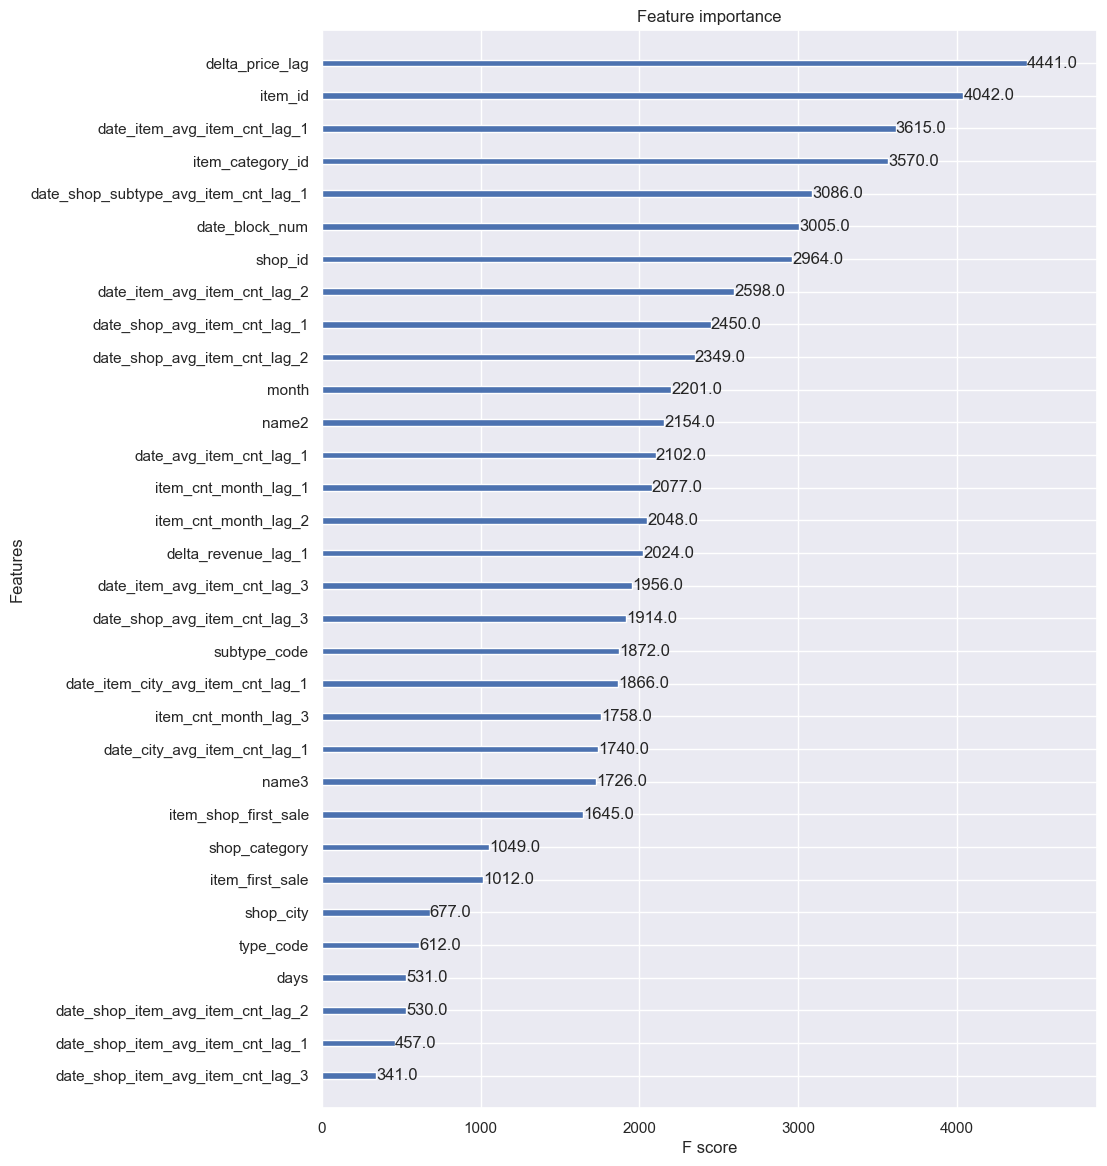

In [113]:
from xgboost import plot_importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(model, (10,14))